<h1 style="text-align: center">Solving the N-Queens Problem with Genetic Programming</h1>

<hr style="border-top: 2px solid #444">

## Development Environment

### Python Dependencies

In [1]:
#!pip install -r pipenv-requirements.txt
#!pipenv install

### Python Imports

In [2]:
import sys
import random
import pandas
import deap
import math
import numpy
from typing import List, Tuple, Iterable
from deap import algorithms, base, creator, tools
import matplotlib.pyplot as plt
from IPython.display import display

print(f"Python version: {sys.version}")
print(f"DEAP version: {deap.__version__}")

Python version: 3.8.5 (tags/v3.8.5:580fbb0, Jul 20 2020, 15:57:54) [MSC v.1924 64 bit (AMD64)]
DEAP version: 1.3


### Helper Methods

#### Visualization Plotter

In [3]:
def plot_generations(generation: List[int], average: List[float], minimum: List[int]):
    plt.figure(figsize=(12, 6))
    plt.grid(True)
    plt.plot(generation, average, label="average")
    plt.plot(generation, minimum, label="minimum")
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.ylim(-1)
    plt.legend(loc="upper right")
    plt.show()

<hr style="border-top: 2px solid #444">

## Part I: Position-index Board Encoding
- For an 8x8 board, there are (8^2)^8 possible states: 281,474,976,710,656
- For an 16x16 board, there are (16^2)^16 possible states: 340,282,366,920,938,463,463,374,607,431,768,211,456

### Register DEAP Toolbox

In [4]:
creator.create("fitness_min_p", base.Fitness, weights=(-1.0,))
creator.create("individual_p", list, fitness=creator.fitness_min_p)

# register individuals and population generators
toolbox_p = base.Toolbox()
toolbox_p.register("range_8", random.randint, 0, 8 ** 2 - 1)
toolbox_p.register("range_16", random.randint, 0, 16 ** 2 - 1)
toolbox_p.register("individual_8", tools.initRepeat, creator.individual_p, toolbox_p.range_8, n=8)
toolbox_p.register("individual_16", tools.initRepeat, creator.individual_p, toolbox_p.range_16, n=16)
toolbox_p.register("population_8", tools.initRepeat, list, toolbox_p.individual_8)
toolbox_p.register("population_16", tools.initRepeat, list, toolbox_p.individual_16)

# register possible genetic mutations
toolbox_p.register("mate", tools.cxTwoPoint)
toolbox_p.register("mutate", tools.mutUniformInt, low=0, up=63, indpb=0.2)
toolbox_p.register("select", tools.selTournament, tournsize=8)

### Rendering Positional Board

In [5]:
def show_positional_grid(positions: Iterable[int], dimensions: Tuple[int, int] = (8 ,8)):
    rows, columns = dimensions
    # construct board in pandas
    board = pandas.DataFrame("", index = range(rows), columns = range(columns))
    # map board
    for queen in positions:
        board[queen % columns][queen // rows] = "👑"
    # display render
    display(board)

### Example 8x8 Individual

In [6]:
example_individual_p = toolbox_p.population_8(n = 1)[0]
print(f"Positions: {example_individual_p}")
print(f"Duplicate positions: {len(example_individual_p) - len(set(example_individual_p))}")
show_positional_grid(example_individual_p)

Positions: [56, 27, 14, 2, 7, 42, 55, 27]
Duplicate positions: 1


,0,1,2,3,4,5,6,7
0,,,👑,,,,,👑
1,,,,,,,👑,
2,,,,,,,,
3,,,,👑,,,,
4,,,,,,,,
5,,,👑,,,,,
6,,,,,,,,👑
7,👑,,,,,,,


#### Fitness Function
Time complexity: `O(|queens|^2)`

In [7]:
def evaluate_position_indexed_fitness(individual: List[int], dimensions: Tuple[int, int] = (8, 8)) -> float:
    rows, columns = dimensions

    fitness: float = 0

    # count all pairs of conflicts
    for x in range(len(individual)):
        x_row, x_column = individual[x] // rows, individual[x] % columns
        for y in range(x + 1, len(individual)):
            y_row, y_column = individual[y] // rows, individual[y] % columns
            if x_row == y_row or x_column == y_column or abs(x_row - y_row) == abs(x_column - y_column):
                fitness += 1

    # penalize duplicate entries significantly
    fitness += 15 * (len(individual) - len(set(individual)))

    return fitness

### Evolutionary Algorithm on a 8x8 Board

#### Evolutionary Computation

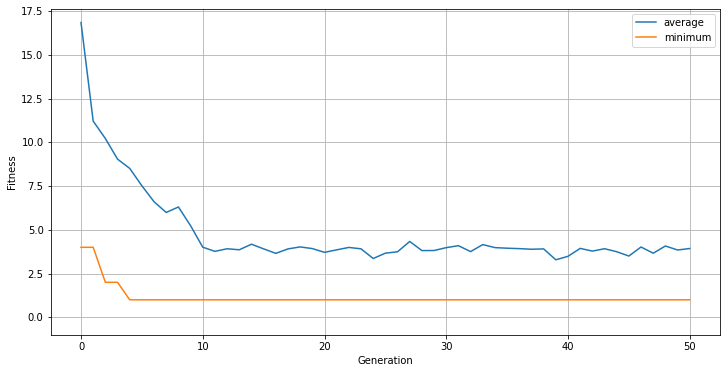

In [8]:
# register fitness evaluation function
toolbox_p.register("evaluate", lambda individual: (evaluate_position_indexed_fitness(individual),))

# statistics logging
stats_p8 = tools.Statistics(key=lambda individual: individual.fitness.values)
stats_p8.register("min", numpy.min)
stats_p8.register("max", numpy.max)
stats_p8.register("avg", numpy.mean)

# log fittest individual with hall of fame record
hall_of_fame_p8 = tools.HallOfFame(maxsize=1)

# run genetic algorithm
_, log_p8 = algorithms.eaSimple(
    toolbox_p.population_8(n=500), toolbox_p,
    cxpb=0.5, mutpb=0.5, ngen=50,
    stats=stats_p8, halloffame=hall_of_fame_p8, verbose=False,
)
plot_generations(*log_p8.select("gen", "avg", "min"))

#### Fittest Individual

In [9]:
print(f"Positions: {hall_of_fame_p8[0]}")
print(f"Fitness: {hall_of_fame_p8[0].fitness}")
show_positional_grid(hall_of_fame_p8[0])

Positions: [61, 0, 44, 33, 50, 31, 14, 11]
Fitness: (1.0,)


,0,1,2,3,4,5,6,7
0,👑,,,,,,,
1,,,,👑,,,👑,
2,,,,,,,,
3,,,,,,,,👑
4,,👑,,,,,,
5,,,,,👑,,,
6,,,👑,,,,,
7,,,,,,👑,,


### Evolutionary Algorithm on a 16x16 Board

#### Evolutionary Computation

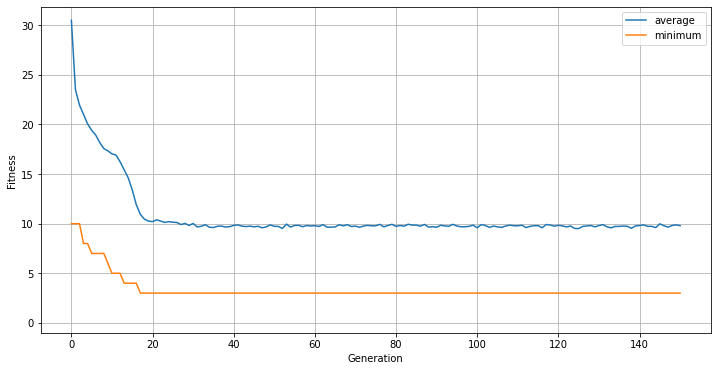

In [10]:
# register fitness evaluation function
toolbox_p.register("evaluate", lambda individual: (evaluate_position_indexed_fitness(individual, dimensions=(16, 16)),))

# statistics logging
stats_p16 = tools.Statistics(key=lambda individual: individual.fitness.values)
stats_p16.register("min", numpy.min)
stats_p16.register("max", numpy.max)
stats_p16.register("avg", numpy.mean)

# log fittest individual with hall of fame record
hall_of_fame_p16 = tools.HallOfFame(maxsize=1)

# run genetic algorithm
_, log_p16 = algorithms.eaSimple(
    toolbox_p.population_16(n=10000), toolbox_p,
    cxpb=0.5, mutpb=0.5, ngen=150,
    stats=stats_p16, halloffame=hall_of_fame_p16, verbose=False,
)
plot_generations(*log_p16.select("gen", "avg", "min"))

#### Fittest Individual

In [11]:
print(f"Positions: {hall_of_fame_p16[0]}")
print(f"Fitness: {hall_of_fame_p16[0].fitness}")
show_positional_grid(hall_of_fame_p16[0], dimensions=(16, 16))

Positions: [61, 21, 148, 142, 7, 32, 60, 218, 194, 107, 153, 79, 161, 230, 115, 8]
Fitness: (3.0,)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,,,,,,,,👑,👑,,,,,,,
1,,,,,,👑,,,,,,,,,,
2,👑,,,,,,,,,,,,,,,
3,,,,,,,,,,,,,👑,👑,,
4,,,,,,,,,,,,,,,,👑
5,,,,,,,,,,,,,,,,
6,,,,,,,,,,,,👑,,,,
7,,,,👑,,,,,,,,,,,,
8,,,,,,,,,,,,,,,👑,
9,,,,,👑,,,,,👑,,,,,,


### Notes
- Despite higher population and generation counts, this board representation suffers for larger board sizes

<hr style="border-top: 2px solid #444">

## II. Row-index Board Encoding

<hr style="border-top: 2px solid #444">

## III. Conclusion